In [1]:
from tools import utils, config, trainer, parts
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
from tools import utils

plt.style.use('fast')
PLOT_DIR = 'plots'

cfg = config.from_yaml("experiments\exp9_supervised_all\config.yaml")
dataset = utils.load_dataset_module(**cfg.data_supervised)
dataset.torch_seed()
test_loader = dataset.get_test_loader(**cfg.data_supervised)
test_dataset = dataset.get_test_dataset()

def get_input_reconstruction(x, trn, model, part_manager, part_i):
    #x = x.unsqueeze(0).to(trn.device)
    _ = model(x)
    
    part_input = part_manager.parts[part_i].get_conv_layer().saved_input
    part_output = part_manager.parts[part_i].get_conv_layer().saved_output
    rec = trn.get_reconstruction(part_manager.parts[part_i])

    return part_input, rec

def get_input_reconstruction_channel(x, trn, model, part_manager, part_i, i_channel):
    part_input = part_manager.parts[part_i].get_conv_layer().saved_input
    rec = trn.get_channel_reconstruction(part_manager.parts[part_i], i_channel)

    return part_input, rec


# Trained model
model_trained = utils.load_model(**cfg.model)
model_trained.load_state_dict(torch.load("experiments\exp9_supervised_all\checkpoint.pth"))

part_manager_trained = parts.PartManager(model_trained)
part_manager_trained.enable_all()

trn_trained = trainer.ModelTrainer(model_trained, cfg.trainer_sup, part_manager_trained)

# Model not trained
model = utils.load_model(**cfg.model)
model.load_state_dict(torch.load("experiments\exp12_overfit_supervised_all\checkpoint.pth"))

part_manager = parts.PartManager(model)
part_manager.enable_all()

trn = trainer.ModelTrainer(model, cfg.trainer_unsup, part_manager)

Loading dataset: data\cifar10.py
Files already downloaded and verified
Files already downloaded and verified
Created 5 parts.
Enable all parts
checkpoint to cuda:0
Created 5 parts.
Enable all parts
checkpoint to cuda:0


### Get samples from each class

In [27]:
N_CLASSES = 10
class_size = 20
classes_to_accumulate = list(range(N_CLASSES))
examples = {i: [] for i in range(N_CLASSES)}

i = 0
while True:
    x, y = test_dataset[i]
    if not y in classes_to_accumulate:
        i+=1
        continue
    
    examples[y].append(i)
    if len(examples[y]) == class_size:
        classes_to_accumulate.remove(y)
        if len(classes_to_accumulate) == 0:
            break
    i+=1

In [28]:
part_i = 1

part_output_trained_list = [[] for _ in range(N_CLASSES)]
part_output_list = [[] for _ in range(N_CLASSES)]

for class_i, class_examples in examples.items():
    for example_i in class_examples:
        x, y = test_dataset[example_i]
        x = x.unsqueeze(0).to(trn.device)
        _ = model_trained(x)
        _ = model(x)
        
        part_output_trained = getattr(part_manager_trained.parts[part_i].get_loss_end_layer(), trainer.SAVED_OUTPUT_NAME)
        part_output = getattr(part_manager.parts[part_i].get_loss_end_layer(), trainer.SAVED_OUTPUT_NAME)

        part_output_trained = torch.squeeze(part_output_trained).cpu().detach().numpy()
        part_output = torch.squeeze(part_output).cpu().detach().numpy()
        
        part_output_trained_list[class_i].append(part_output_trained)
        part_output_list[class_i].append(part_output)
    
activations_trained = np.array(part_output_trained_list)
activations = np.array(part_output_list)

activations_trained.shape # i_class, i_example, i_kernel, h, w

D:\Miniconda3\envs\env\lib\site-packages\torch\nn\modules\module.py:1102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)


(10, 20, 80, 12, 12)

In [29]:
def get_flattened_activations(w, class_i, channel_i):
    flat_size = class_size
    kernel_h = w.shape[-2]

    flattened_kernel = np.zeros((kernel_h, flat_size * kernel_h))
    for example_i in range(w.shape[1]):
        flattened_kernel[:, example_i * kernel_h: (example_i+1) * kernel_h] = w[class_i, example_i, channel_i]
    return flattened_kernel

class_i = 0
channel_i = 0
flattened_activations_trained = get_flattened_activations(activations_trained, class_i, channel_i)
flattened_activations = get_flattened_activations(activations, class_i, channel_i)

Text(0.5, 1.0, 'Trained model activation histogram')

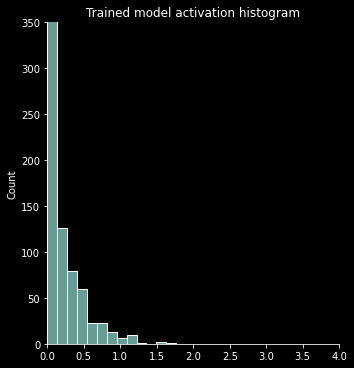

In [30]:
sns.displot(flattened_activations_trained.flatten())
plt.ylim([0, 350])
plt.xlim([0, 4])
plt.title("Trained model activation histogram")

Text(0.5, 1.0, 'Not trained activation histogram')

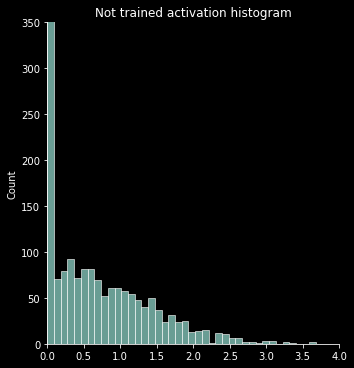

In [31]:
sns.displot(flattened_activations.flatten())
plt.ylim([0, 350])
plt.xlim([0, 4])
plt.title("Not trained activation histogram")

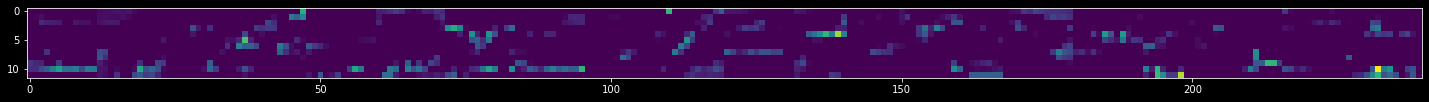

In [36]:
plt.figure(figsize=(25, 5))
plt.imshow(flattened_activations_trained)

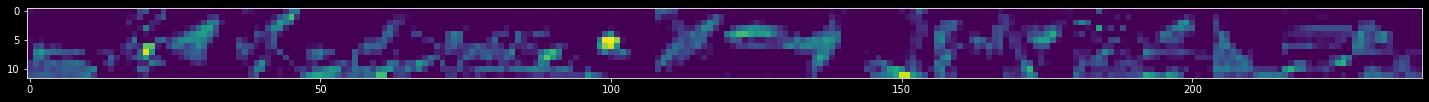

In [37]:
plt.figure(figsize=(25, 5))
plt.imshow(flattened_activations)

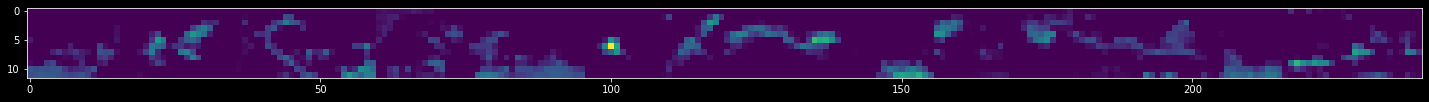

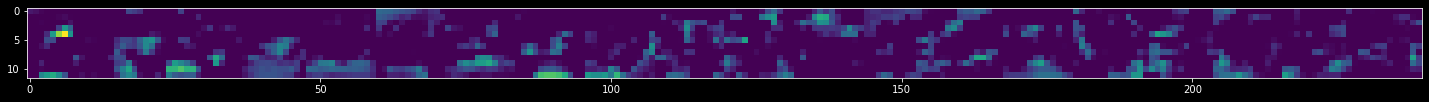

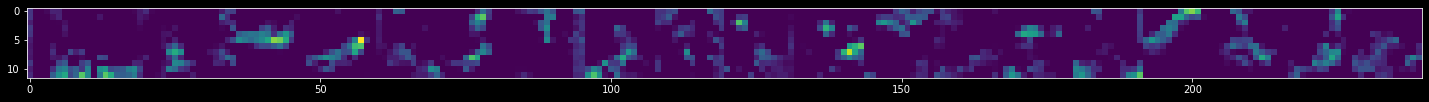

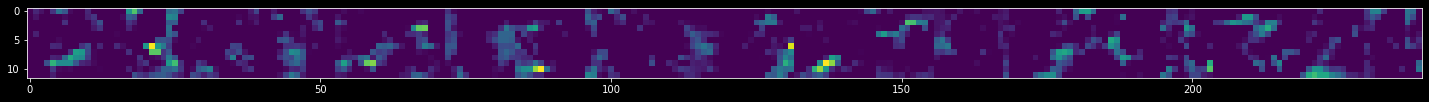

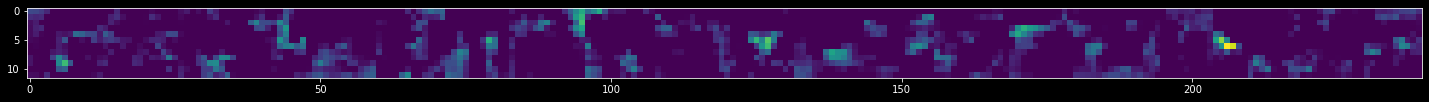

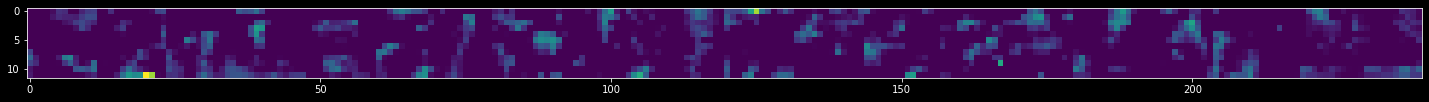

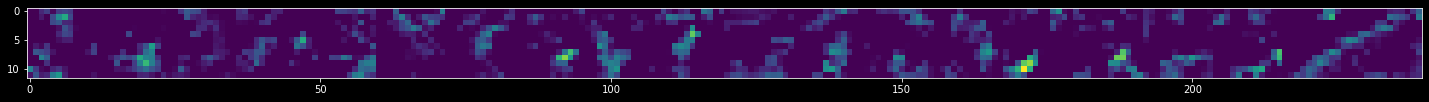

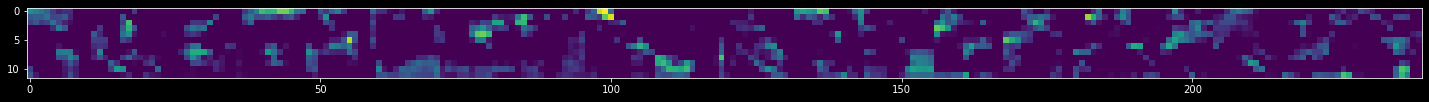

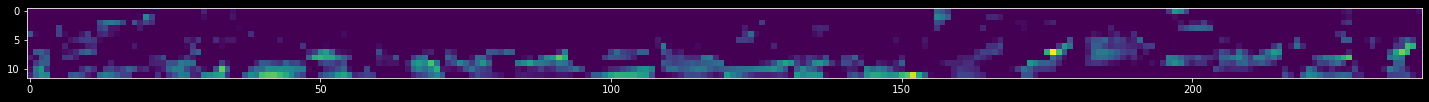

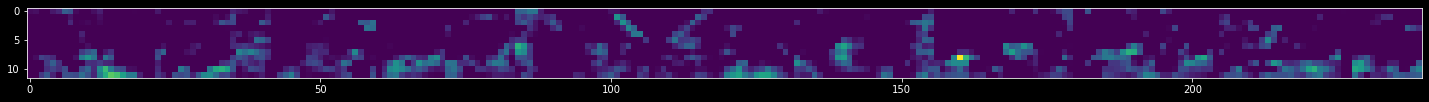

In [38]:
KERNEL_I = 1
for class_i in range(N_CLASSES):
    plt.figure(figsize=(25, 5))
    flat_kernel = get_flattened_activations(activations_trained, class_i, KERNEL_I)
    plt.imshow(flat_kernel)

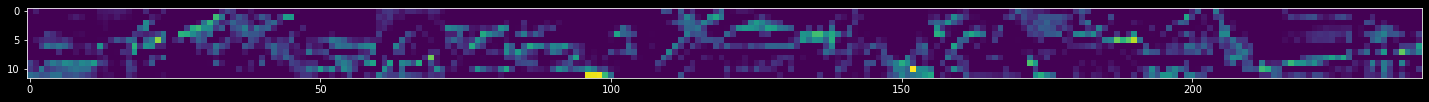

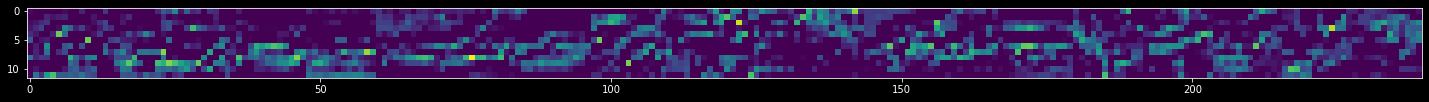

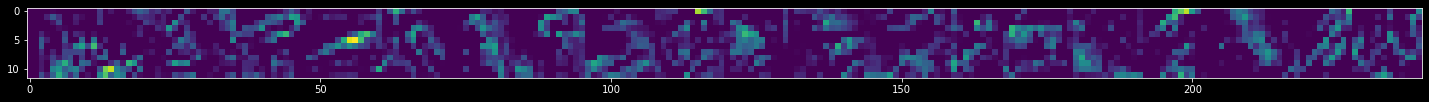

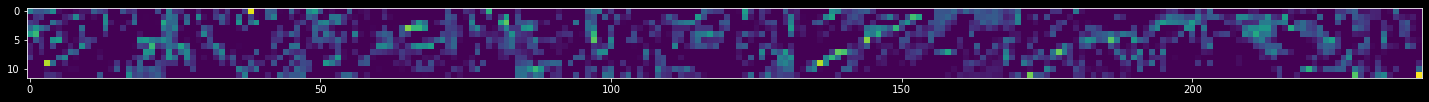

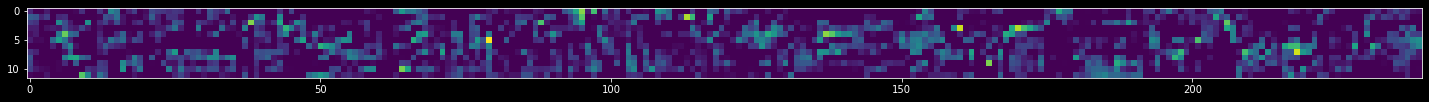

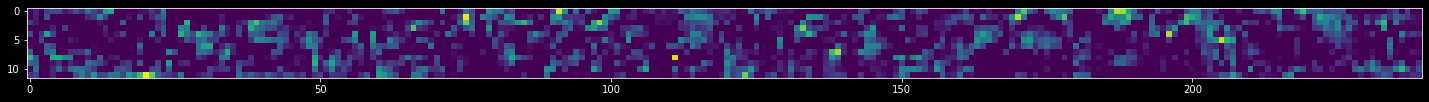

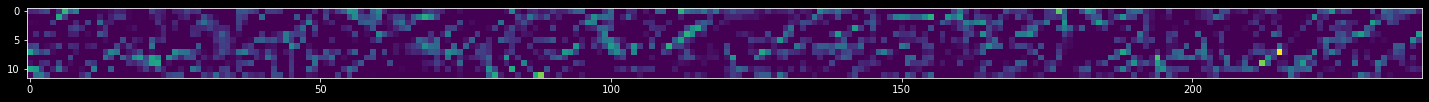

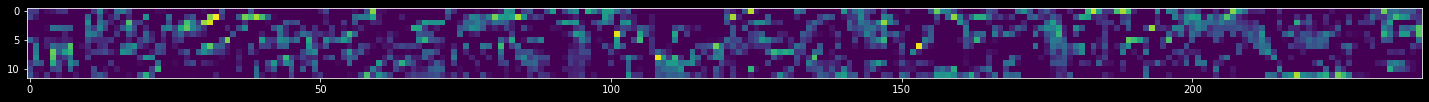

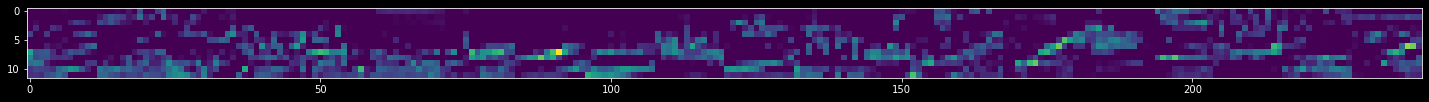

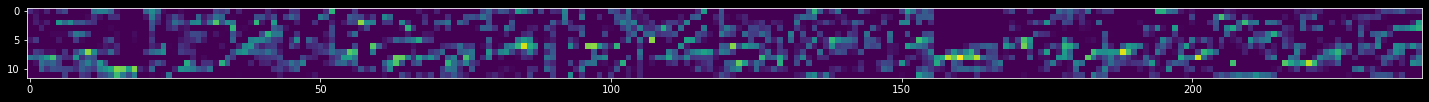

In [39]:
for class_i in range(N_CLASSES):
    plt.figure(figsize=(25, 5))
    flat_kernel = get_flattened_activations(activations, class_i, KERNEL_I)
    plt.imshow(flat_kernel)

### Activations are less correlated in trained model

In [ ]:
def gram_matrix_mean(gen):
    batch_size,channel,height,width=gen.shape
    mean_vals = torch.zeros(batch_size)
    for b in range(batch_size):
        gen_batch = gen[b]
        G=torch.mm(gen_batch.view(channel,height*width),gen_batch.view(channel,height*width).t())
        mean_vals[b] = G.mean()
    return mean_vals.mean()

In [ ]:
gram_matrix_mean(torch.tensor(activations))

In [ ]:
gram_matrix_mean(torch.tensor(activations_trained))

In [ ]:
for i in range(len(activations)):
    print(gram_matrix_mean(torch.tensor(activations[i]).unsqueeze(0)))

In [ ]:
for i in range(len(activations)):
    print(gram_matrix_mean(torch.tensor(activations_trained[i]).unsqueeze(0)))